## Mask Classification

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from tqdm import tqdm
import xml.etree.ElementTree as ET
import random as rn
import torch
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from PIL import Image
import gc
import os
from collections import OrderedDict
import glob 
torch.cuda.empty_cache()
gc.collect()


20

### Preparing Data

In [3]:
data_dir = 'mask_data'
all_data = 'all_data'

train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor): 
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [5]:
# Define transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.Resize(256),#transforms.RandomResizedCrop(224),
                                          transforms.CenterCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225]),
                                          AddGaussianNoise(0.1,0.08)])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder

training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=16)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=16)

# Create Model

Load in the pretrained VGG19 model. Freeze the feature and average pool weights and construct the classification component.

<img src="sketch2.png">

In [6]:
model = models.vgg19(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [7]:
for parameter in model.parameters():
    parameter.requires_grad = False

classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 10, bias= True)),
                                        ('tanh1', nn.Tanh()),
                                        ('dropout', nn.Dropout(p=0.25)),
                                        ('fc2',nn.Linear(10,2,bias=True)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

### Training, Validation, Testing

In [8]:
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [9]:
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

using cuda device
Epoch: 1/6..  Training Loss: 0.000..  Validation Loss: 0.703..  Validation Accuracy: 0.473
Finished epoch 1 on overall step 1.
Finished epoch 1 on overall step 2.
Finished epoch 1 on overall step 3.
Finished epoch 1 on overall step 4.
Finished epoch 1 on overall step 5.
Finished epoch 1 on overall step 6.
Finished epoch 1 on overall step 7.
Finished epoch 1 on overall step 8.
Finished epoch 1 on overall step 9.
Finished epoch 1 on overall step 10.
Finished epoch 1 on overall step 11.
Finished epoch 1 on overall step 12.
Finished epoch 1 on overall step 13.
Finished epoch 1 on overall step 14.
Finished epoch 1 on overall step 15.
Finished epoch 1 on overall step 16.
Finished epoch 1 on overall step 17.
Finished epoch 1 on overall step 18.
Finished epoch 1 on overall step 19.
Finished epoch 1 on overall step 20.
Finished epoch 1 on overall step 21.
Finished epoch 1 on overall step 22.
Finished epoch 1 on overall step 23.
Finished epoch 1 on overall step 24.
Finished epo

Finished epoch 2 on overall step 212.
Finished epoch 2 on overall step 213.
Finished epoch 2 on overall step 214.
Finished epoch 2 on overall step 215.
Finished epoch 2 on overall step 216.
Finished epoch 2 on overall step 217.
Finished epoch 2 on overall step 218.
Finished epoch 2 on overall step 219.
Finished epoch 2 on overall step 220.
Finished epoch 2 on overall step 221.
Finished epoch 2 on overall step 222.
Finished epoch 2 on overall step 223.
Finished epoch 2 on overall step 224.
Finished epoch 2 on overall step 225.
Finished epoch 2 on overall step 226.
Finished epoch 2 on overall step 227.
Finished epoch 2 on overall step 228.
Finished epoch 2 on overall step 229.
Finished epoch 2 on overall step 230.
Finished epoch 2 on overall step 231.
Finished epoch 2 on overall step 232.
Finished epoch 2 on overall step 233.
Finished epoch 2 on overall step 234.
Finished epoch 2 on overall step 235.
Finished epoch 2 on overall step 236.
Finished epoch 2 on overall step 237.
Finished epo

Finished epoch 3 on overall step 423.
Finished epoch 3 on overall step 424.
Finished epoch 3 on overall step 425.
Finished epoch 3 on overall step 426.
Finished epoch 3 on overall step 427.
Finished epoch 3 on overall step 428.
Finished epoch 3 on overall step 429.
Finished epoch 3 on overall step 430.
Finished epoch 3 on overall step 431.
Finished epoch 3 on overall step 432.
Finished epoch 3 on overall step 433.
Finished epoch 3 on overall step 434.
Finished epoch 3 on overall step 435.
Finished epoch 3 on overall step 436.
Finished epoch 3 on overall step 437.
Finished epoch 3 on overall step 438.
Finished epoch 3 on overall step 439.
Finished epoch 3 on overall step 440.
Finished epoch 3 on overall step 441.
Finished epoch 3 on overall step 442.
Finished epoch 3 on overall step 443.
Finished epoch 3 on overall step 444.
Finished epoch 3 on overall step 445.
Finished epoch 3 on overall step 446.
Finished epoch 3 on overall step 447.
Finished epoch 3 on overall step 448.
Finished epo

Finished epoch 4 on overall step 634.
Finished epoch 4 on overall step 635.
Finished epoch 4 on overall step 636.
Finished epoch 4 on overall step 637.
Finished epoch 4 on overall step 638.
Finished epoch 4 on overall step 639.
Finished epoch 4 on overall step 640.
Finished epoch 4 on overall step 641.
Finished epoch 4 on overall step 642.
Finished epoch 4 on overall step 643.
Finished epoch 4 on overall step 644.
Finished epoch 4 on overall step 645.
Finished epoch 4 on overall step 646.
Finished epoch 4 on overall step 647.
Finished epoch 4 on overall step 648.
Finished epoch 4 on overall step 649.
Finished epoch 4 on overall step 650.
Finished epoch 4 on overall step 651.
Finished epoch 4 on overall step 652.
Finished epoch 4 on overall step 653.
Finished epoch 4 on overall step 654.
Finished epoch 4 on overall step 655.
Finished epoch 4 on overall step 656.
Finished epoch 4 on overall step 657.
Finished epoch 4 on overall step 658.
Finished epoch 4 on overall step 659.
Finished epo

Finished epoch 5 on overall step 845.
Finished epoch 5 on overall step 846.
Finished epoch 5 on overall step 847.
Finished epoch 5 on overall step 848.
Finished epoch 5 on overall step 849.
Finished epoch 5 on overall step 850.
Finished epoch 5 on overall step 851.
Finished epoch 5 on overall step 852.
Finished epoch 5 on overall step 853.
Finished epoch 5 on overall step 854.
Finished epoch 5 on overall step 855.
Finished epoch 5 on overall step 856.
Finished epoch 5 on overall step 857.
Finished epoch 5 on overall step 858.
Finished epoch 5 on overall step 859.
Finished epoch 5 on overall step 860.
Finished epoch 5 on overall step 861.
Finished epoch 5 on overall step 862.
Finished epoch 5 on overall step 863.
Finished epoch 5 on overall step 864.
Finished epoch 5 on overall step 865.
Finished epoch 5 on overall step 866.
Finished epoch 5 on overall step 867.
Finished epoch 5 on overall step 868.
Finished epoch 5 on overall step 869.
Finished epoch 5 on overall step 870.
Finished epo

Finished epoch 6 on overall step 1055.
Finished epoch 6 on overall step 1056.
Finished epoch 6 on overall step 1057.
Finished epoch 6 on overall step 1058.
Finished epoch 6 on overall step 1059.
Finished epoch 6 on overall step 1060.
Finished epoch 6 on overall step 1061.
Finished epoch 6 on overall step 1062.
Finished epoch 6 on overall step 1063.
Finished epoch 6 on overall step 1064.
Finished epoch 6 on overall step 1065.
Finished epoch 6 on overall step 1066.
Finished epoch 6 on overall step 1067.
Finished epoch 6 on overall step 1068.
Finished epoch 6 on overall step 1069.
Finished epoch 6 on overall step 1070.
Finished epoch 6 on overall step 1071.
Finished epoch 6 on overall step 1072.
Finished epoch 6 on overall step 1073.
Finished epoch 6 on overall step 1074.
Finished epoch 6 on overall step 1075.
Finished epoch 6 on overall step 1076.
Finished epoch 6 on overall step 1077.
Finished epoch 6 on overall step 1078.
Finished epoch 6 on overall step 1079.
Finished epoch 6 on overa

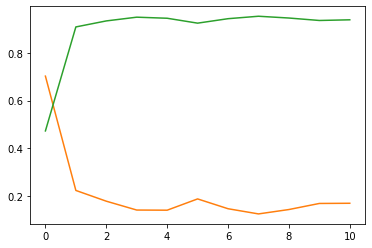

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("using {} device".format(device))

val_loss_history = []
val_accuracy_history = []
loss_history = []

def train_classifier(epochs, valid_gap):
    
    """
    epochs: Number of epochs to train.
    valid_gap: Number of iterations between each validation run.
    
    Trains the model for the specified number of epochs with validation tests. 
    """
    
    steps = 0
    model.to('cuda')

    for e in range(epochs):

        model.train()

        running_loss = 0

        for images, labels in iter(train_loader):
            if steps % valid_gap == 0:

                model.eval()

                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, validate_loader, criterion)

                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/valid_gap),
                      "Validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
                      "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader))) 
                
                val_loss_history.append(validation_loss/len(validate_loader))
                val_accuracy_history.append(accuracy/len(validate_loader))
                running_loss = 0
                model.train()
                
            steps += 1

            images, labels = images.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
                
            running_loss += loss.item()
                
            print(f"Finished epoch {e+1} on overall step {steps}.")
         
        
    plt.plot(loss_history)
    plt.plot(val_loss_history)
    plt.plot(val_accuracy_history)
    
train_classifier(6,100)                    

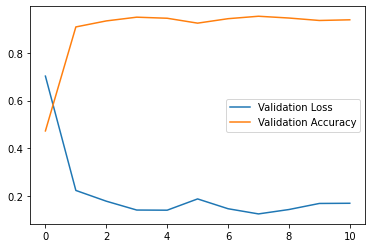

In [16]:
plt.plot(val_loss_history, label = 'Validation Loss')
plt.plot(val_accuracy_history, label = "Validation Accuracy")
plt.legend()

In [17]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [13]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    model.eval()
    # Loop over all examples in test set
    for i, (data, target) in enumerate(test_loader):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model.forward(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)
        
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [14]:
def test_UH( models, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    for model in models:
        model.eval()
    # Loop over all examples in test set
    for i, (data, target) in enumerate(test_loader):
        
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        model_bad = models[np.random.randint(0,high=len(models))]
        output = model_bad.forward(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model_bad.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = models[np.random.randint(0,high=len(models))].forward(perturbed_data)
        
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [18]:
accuracies = []
examples = []
epsilons = [0,0.2,0.4,0.6,0.8]
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=1)
# Run test for each epsilon
for eps in epsilons:
    acc,ex = test(model,'cuda',test_loader,eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 864 / 987 = 0.8753799392097265
Epsilon: 0.2	Test Accuracy = 846 / 987 = 0.8571428571428571
Epsilon: 0.4	Test Accuracy = 849 / 987 = 0.8601823708206687
Epsilon: 0.6	Test Accuracy = 850 / 987 = 0.8611955420466059
Epsilon: 0.8	Test Accuracy = 848 / 987 = 0.8591691995947315


Text(0.5, 1.0, 'Accuracy and Epsilon')

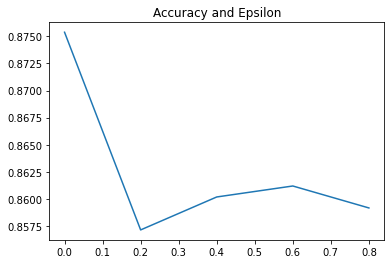

In [19]:
plt.plot(epsilons, accuracies)
plt.title("Accuracy and Epsilon")

In [20]:
def test_accuracy(model, test_loader):

    # Do validation on the test set
    model.eval()
    model.to('cuda')

    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(test_loader):
    
            images, labels = images.to('cuda'), labels.to('cuda')
            
            output = model.forward(images)

            probabilities = torch.exp(output)
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))    
        
        
test_accuracy(model, test_loader)

Test Accuracy: 0.935157060623169


In [23]:
def test_accuracy_uniform_hash(models, test_loader):

    # Do validation on the test set
    for model in models:
        model.eval()
        model.to('cuda')
    
    n = len(models)
    
    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(test_loader):
    
            images, labels = images.to('cuda'), labels.to('cuda')
            
            output = models[np.random.randint(0,high=n)].forward(images)

            probabilities = torch.exp(output)
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))    
        
        
test_accuracy_uniform_hash([model1,model2,model3], test_loader)

Test Accuracy: 0.9493414163589478


## Saving and Loading Model


In [21]:
# Save the checkpoint

def save_checkpoint(model):

    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'arch': "vgg19",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'model.pth')
    
save_checkpoint(model)    

In [22]:
def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    if checkpoint['arch'] == 'vgg19':
        
        model = models.vgg19(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Architecture not recognized.")
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    # Build custom classifier
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 10, bias= True)),
                                        ('tanh1', nn.Tanh()),
                                        ('dropout', nn.Dropout(p=0.25)),
                                        ('fc2',nn.Linear(10,2,bias=True)),
                                        ('output', nn.LogSoftmax(dim=1))]))

    model.classifier = classifier
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to("cuda")
    
    return model

model1 = load_checkpoint('model_1.pth')
model2 = load_checkpoint('model_2.pth')
model3 = load_checkpoint('model_3.pth')

### Prediction Given an Image

In [24]:
from PIL import Image

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path)

    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    np_image = np.array(pil_image)[:,:,:3]/255
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

In [25]:
def predict(image_path, model, topk=2):
    
    image = process_image(image_path)
    #print(image.shape)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    #print(idx_to_class)
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes


M_i = {'1':'No Mask', '2':'Mask'}

probs,classes = predict('doctor.jpg',model)

print(probs)
print(classes)
print(f"Prediction: {M_i[classes[0]]}")

[0.9943848848342896, 0.00561508210375905]
['2', '1']
Prediction: Mask


In [ ]:
def predict_uniform_hash(image_path, models, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    #print(image.shape)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    p = np.random.randint(0,len(models))
    
    print("Using model", p+1)
    output = models[np.random.randint(0,len(models))].forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    #print(idx_to_class)
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes

M_i = {'1':'No Mask', '2':'Mask'}
probs,classes = predict_uniform_hash('aaronzhu2.png',[model1,model2,model3])

print(probs)
print(classes)
print(f"Prediction: {M_i[classes[0]]}")